# Reinforcement Learning Prep (Contrail Scores)

This notebook prepares segment-level features, counterfactual scores for UP/DOWN actions, and a baseline one-change optimizer per flight.


## 1) Load data


In [64]:
import sys
print('Kernel OK:', sys.executable)


Kernel OK: c:\Users\HiWi\Desktop\Terril\05_python_venv\Scripts\python.exe


In [69]:
from pathlib import Path
import time
import pandas as pd

ROOT = Path.cwd().parent
PROCESSED_SCORES = ROOT / 'data' / 'processed' / 'scores' / 'states_europe' / '2025-01-13_2025-01-14'
PROCESSED_WEATHER = ROOT / 'data' / 'processed' / 'weather_ERA5' / 'states_europe' / '2025-01-13_2025-01-14'

SEG = PROCESSED_SCORES / 'segments_with_era5_rhi_issr.parquet'
FS  = PROCESSED_SCORES / 'flight_scores_rhi_issr.parquet'
TOP = PROCESSED_SCORES / 'flight_scores_top2pct.parquet'

t0 = time.time()
segments = pd.read_parquet(
    SEG,
    columns=['flight_id','mid_time','mid_lon','dist_km','dt_utc',
             'era5_time','plev_hpa','lat_g','lon_g','T_K','q_kgkg','RHi','ISSR','segment_score']
)
print('segments loaded in', round(time.time() - t0, 2), 's:', segments.shape)

t0 = time.time()
flight_scores = pd.read_parquet(FS)
top2 = pd.read_parquet(TOP)
print('flight_scores/top2 loaded in', round(time.time() - t0, 2), 's')

t0 = time.time()
era5 = pd.read_parquet(
    PROCESSED_WEATHER / 'era5_pl_europe_20250113_T_q.parquet',
    columns=['time','plev_hpa','lat','lon','T_K','q_kgkg']
)
print('era5 loaded in', round(time.time() - t0, 2), 's:', era5.shape)


segments loaded in 0.21 s: (1336164, 14)
flight_scores/top2 loaded in 0.02 s
era5 loaded in 0.09 s: (3593880, 6)


## 2) Hourly time alignment (segments and ERA5)


In [70]:
segments = segments.copy()
segments["time_hour"] = pd.to_datetime(segments["era5_time"], utc=True).dt.tz_convert(None).dt.floor("h")

era5 = era5.copy()
era5["time_hour"] = pd.to_datetime(era5["time"], utc=True).dt.tz_convert(None).dt.floor("h")

print("segments unique hours:", segments["time_hour"].nunique())
print("era5 unique hours:", era5["time_hour"].nunique())


segments unique hours: 25
era5 unique hours: 24


## 3) Define UP/DOWN pressure levels
ERA5 is available on discrete pressure levels; UP means lower pressure, DOWN means higher pressure.


In [71]:
import numpy as np

levels = np.array([200, 225, 250, 300, 350], dtype=int)
idx = {int(p): i for i, p in enumerate(levels)}

plev = segments["plev_hpa"].astype(int)
i = plev.map(idx).astype(int).to_numpy()

segments["plev_up"]   = levels[np.maximum(i - 1, 0)]
segments["plev_down"] = levels[np.minimum(i + 1, len(levels) - 1)]

print(segments[["plev_hpa","plev_up","plev_down"]].head(10))


   plev_hpa  plev_up  plev_down
0       350      300        350
1       300      250        350
2       300      250        350
3       250      225        300
4       250      225        300
5       225      200        250
6       225      200        250
7       200      200        225
8       200      200        225
9       200      200        225


## 4) Drop segments with hours missing in ERA5 and lookup T/q for UP/DOWN


In [72]:
# keep only rows whose time_hour exists in ERA5
valid_hours = set(era5["time_hour"].unique())
before = len(segments)
segments = segments[segments["time_hour"].isin(valid_hours)].copy()
after = len(segments)
print("Dropped rows due to missing ERA5 hour:", before - after)

# build unique ERA5 index at hourly resolution
era5_unique = (era5
               .drop_duplicates(["time_hour","plev_hpa","lat","lon"])
               .set_index(["time_hour","plev_hpa","lat","lon"])[["T_K","q_kgkg"]])

# UP lookup
key_up = pd.MultiIndex.from_arrays(
    [
        segments["time_hour"].to_numpy(),
        segments["plev_up"].astype(int).to_numpy(),
        segments["lat_g"].to_numpy(),
        segments["lon_g"].to_numpy(),
    ],
    names=["time_hour","plev_hpa","lat","lon"]
)
up_vals = era5_unique.reindex(key_up)
segments["T_K_up"] = up_vals["T_K"].to_numpy()
segments["q_kgkg_up"] = up_vals["q_kgkg"].to_numpy()

# DOWN lookup
key_down = pd.MultiIndex.from_arrays(
    [
        segments["time_hour"].to_numpy(),
        segments["plev_down"].astype(int).to_numpy(),
        segments["lat_g"].to_numpy(),
        segments["lon_g"].to_numpy(),
    ],
    names=["time_hour","plev_hpa","lat","lon"]
)

down_vals = era5_unique.reindex(key_down)
segments["T_K_down"] = down_vals["T_K"].to_numpy()
segments["q_kgkg_down"] = down_vals["q_kgkg"].to_numpy()

print("UP lookup match rate:", segments["T_K_up"].notna().mean())
print("DOWN lookup match rate:", segments["T_K_down"].notna().mean())


Dropped rows due to missing ERA5 hour: 8380
UP lookup match rate: 1.0
DOWN lookup match rate: 1.0


## 5) Compute RHi/ISSR for HOLD, UP, DOWN


In [73]:
import numpy as np

def e_si_pa(T):
    # Saturation vapor pressure over ice (Pa), Murphy & Koop (2005)
    return np.exp(9.550426 - (5723.265 / T) + 3.53068*np.log(T) - 0.00728332*T)

def vapor_pressure_from_q(p_pa, q):
    w = q / np.clip(1 - q, 1e-12, None)
    eps = 0.622
    return (w * p_pa) / (eps + w)

def compute_rhi(p_hpa, T_K, q_kgkg):
    p_pa = np.asarray(p_hpa, dtype=float) * 100.0
    T = np.asarray(T_K, dtype=float)
    q = np.asarray(q_kgkg, dtype=float)
    e = vapor_pressure_from_q(p_pa, q)
    esi = e_si_pa(T)
    return 100.0 * (e / np.clip(esi, 1e-9, None))

# HOLD already exists; recompute only if needed
# segments["RHi"] = compute_rhi(segments["plev_hpa"], segments["T_K"], segments["q_kgkg"])
# segments["ISSR"] = segments["RHi"] > 100.0

segments["RHi_up"] = compute_rhi(segments["plev_up"], segments["T_K_up"], segments["q_kgkg_up"])
segments["ISSR_up"] = segments["RHi_up"] > 100.0

segments["RHi_down"] = compute_rhi(segments["plev_down"], segments["T_K_down"], segments["q_kgkg_down"])
segments["ISSR_down"] = segments["RHi_down"] > 100.0

print(segments[["RHi","ISSR","RHi_up","ISSR_up","RHi_down","ISSR_down"]].head(5))


         RHi   ISSR     RHi_up  ISSR_up   RHi_down  ISSR_down
0  15.792362  False  21.861191    False  15.792362      False
1  18.276783  False  63.716047    False  17.657800      False
2  18.276783  False  63.716047    False  17.657800      False
3  57.500223  False  74.742171    False  15.828331      False
4  57.500223  False  74.742171    False  15.828331      False


## 6) Compute segment scores for UP/DOWN


In [74]:
import numpy as np
import pandas as pd

# recompute is_night consistently (optional)
local_hour = (pd.to_datetime(segments["dt_utc"]).dt.hour + segments["mid_lon"] / 15.0) % 24
segments["is_night"] = (local_hour >= 18) | (local_hour < 6)

night_w = np.where(segments["is_night"].to_numpy(), 1.5, 1.0)
dist = segments["dist_km"].to_numpy(dtype=float)

# HOLD check (optional)
excess_hold = np.maximum(0.0, (segments["RHi"].to_numpy(dtype=float) - 100.0) / 20.0)
score_hold_recalc = dist * excess_hold * night_w * segments["ISSR"].astype(float).to_numpy()
mae = np.mean(np.abs(score_hold_recalc - segments["segment_score"].to_numpy(dtype=float)))
print("MAE vs stored segment_score:", mae)

# UP score
excess_up = np.maximum(0.0, (segments["RHi_up"].to_numpy(dtype=float) - 100.0) / 20.0)
segments["segment_score_up"] = dist * excess_up * night_w * segments["ISSR_up"].astype(float).to_numpy()

# DOWN score
excess_down = np.maximum(0.0, (segments["RHi_down"].to_numpy(dtype=float) - 100.0) / 20.0)
segments["segment_score_down"] = dist * excess_down * night_w * segments["ISSR_down"].astype(float).to_numpy()

print(segments[["segment_score","segment_score_up","segment_score_down"]].head(5))


MAE vs stored segment_score: 0.0
   segment_score  segment_score_up  segment_score_down
0            0.0               0.0                 0.0
1            0.0               0.0                 0.0
2            0.0               0.0                 0.0
3            0.0               0.0                 0.0
4            0.0               0.0                 0.0


## 7) Build cost table


In [75]:
import pandas as pd

cost_table = segments[[
    "flight_id", "mid_time", "dist_km",
    "plev_hpa", "plev_up", "plev_down",
    "segment_score", "segment_score_up", "segment_score_down",
    "is_night", "RHi", "ISSR", "RHi_up", "ISSR_up", "RHi_down", "ISSR_down"
]].copy()

cost_table = cost_table.sort_values(["flight_id", "mid_time"])
cost_table["step_idx"] = cost_table.groupby("flight_id").cumcount()

cost_table["cost_hold"] = cost_table["segment_score"]
cost_table["cost_up"]   = cost_table["segment_score_up"]
cost_table["cost_down"] = cost_table["segment_score_down"]

print("cost_table table shape:", cost_table.shape)
print("steps per flight summary:")
print(cost_table.groupby("flight_id").size().describe())


rl table shape: (1327784, 20)
steps per flight summary:
count    19916.000000
mean        66.669211
std         51.389057
min          1.000000
25%         25.000000
50%         55.000000
75%         99.000000
max        553.000000
dtype: float64


## 8) Baseline: no-change (existing flight path)


In [76]:
import pandas as pd

# Baseline: no-change (existing flight path)
baseline = cost_table.groupby("flight_id")["cost_hold"].sum().rename("baseline_cost").reset_index()
print(baseline["baseline_cost"].describe())


count    19916.000000
mean        25.863060
std         76.134320
min          0.000000
25%          0.000000
50%          0.000000
75%         11.931408
max       1438.642334
Name: baseline_cost, dtype: float64


## 9) Method 1: One-change + fuel constraint (exact)

We keep at most one change per flight, and add a simple fuel proxy. This is exact optimization over the constrained space.


In [77]:
import numpy as np
import pandas as pd

# Fuel proxy options (choose one):
# 1) fixed penalty per change
FUEL_PENALTY = 0.05  # adjust as needed

# Optionally scale by distance after change (set to True if desired)
SCALE_BY_DISTANCE = False

def best_one_change_with_fuel(df_f):
    hold = df_f["cost_hold"].to_numpy()
    up   = df_f["cost_up"].to_numpy()
    down = df_f["cost_down"].to_numpy()
    dist = df_f["dist_km"].to_numpy()

    n = len(hold)
    hold_prefix = np.cumsum(hold)
    up_suffix   = np.cumsum(up[::-1])[::-1]
    down_suffix = np.cumsum(down[::-1])[::-1]

    # fuel penalty applied once at switch; optionally scaled by remaining distance
    if SCALE_BY_DISTANCE:
        rem_dist = np.cumsum(dist[::-1])[::-1]
        fuel_pen = FUEL_PENALTY * rem_dist
    else:
        fuel_pen = FUEL_PENALTY * np.ones(n)

    best_cost = hold_prefix[-1]
    best_k = None
    best_action = "HOLD"

    hold_before = np.concatenate([[0.0], hold_prefix[:-1]])
    total_up = hold_before + up_suffix + fuel_pen
    k_up = int(np.argmin(total_up))
    if total_up[k_up] < best_cost:
        best_cost = float(total_up[k_up])
        best_k = k_up
        best_action = "UP"

    total_down = hold_before + down_suffix + fuel_pen
    k_down = int(np.argmin(total_down))
    if total_down[k_down] < best_cost:
        best_cost = float(total_down[k_down])
        best_k = k_down
        best_action = "DOWN"

    return pd.Series({"best_cost": best_cost, "best_k": best_k, "best_action": best_action})

cost_sorted = cost_table.sort_values(["flight_id","step_idx"])
best_fuel = cost_sorted.groupby("flight_id", group_keys=False).apply(best_one_change_with_fuel).reset_index()

no_change = cost_sorted.groupby("flight_id")["cost_hold"].sum().rename("no_change_cost").reset_index()
best_fuel = best_fuel.merge(no_change, on="flight_id", how="left")
best_fuel["improvement_abs"] = best_fuel["no_change_cost"] - best_fuel["best_cost"]
best_fuel["improvement_pct"] = np.where(best_fuel["no_change_cost"]>0, best_fuel["improvement_abs"]/best_fuel["no_change_cost"], 0.0)

print(best_fuel[["best_action","best_k","no_change_cost","best_cost","improvement_abs","improvement_pct"]].head(10))
print("Share of flights where change is beneficial:", (best_fuel["improvement_abs"]>0).mean())
print("Chosen action counts:", best_fuel["best_action"].value_counts())


C:\Users\HiWi\AppData\Local\Temp\ipykernel_16524\2003823566.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_fuel = rl_sorted.groupby("flight_id", group_keys=False).apply(best_one_change_with_fuel).reset_index()


  best_action  best_k  no_change_cost  best_cost  improvement_abs  \
0        HOLD     NaN        0.000000   0.000000         0.000000   
1        HOLD     NaN        0.000000   0.000000         0.000000   
2        DOWN    85.0       62.743794  11.086247        51.657547   
3        HOLD     NaN        0.000000   0.000000         0.000000   
4        DOWN   173.0        9.958803   0.050000         9.908803   
5        HOLD     NaN        0.000000   0.000000         0.000000   
6        HOLD     NaN        0.000000   0.000000         0.000000   
7        HOLD     NaN        0.000000   0.000000         0.000000   
8        HOLD     NaN        0.000000   0.000000         0.000000   
9          UP     0.0        0.245275   0.050000         0.195275   

   improvement_pct  
0         0.000000  
1         0.000000  
2         0.823309  
3         0.000000  
4         0.994979  
5         0.000000  
6         0.000000  
7         0.000000  
8         0.000000  
9         0.796147  
Share of 

## 10) Method 2 (preferred): Hourly decision grid + fuel + max changes

We restrict decisions to hour boundaries. This aligns with ERA5 resolution and improves operational realism.
We solve the optimal policy with dynamic programming (exact for this constrained setup).


In [78]:
import numpy as np
import pandas as pd

MAX_CHANGES = 2  # set 1 or 2
FUEL_PENALTY = 0.05
SCALE_BY_DISTANCE = False

# Mark hour boundaries for each flight (True when time_hour changes)
cost_hourly = cost_table.copy()
cost_hourly["time_hour"] = pd.to_datetime(segments["time_hour"]).values
cost_hourly = cost_hourly.sort_values(["flight_id","step_idx"])
cost_hourly["is_hour_boundary"] = cost_hourly.groupby("flight_id")["time_hour"].diff().dt.total_seconds().fillna(0).ne(0)

# Dynamic programming per flight
def best_hourly_policy(df_f):
    hold = df_f["cost_hold"].to_numpy()
    up   = df_f["cost_up"].to_numpy()
    down = df_f["cost_down"].to_numpy()
    dist = df_f["dist_km"].to_numpy()
    is_boundary = df_f["is_hour_boundary"].to_numpy()
    n = len(hold)

    # DP state: step t, changes used k, current mode (0=hold,1=up,2=down)
    # We allow switching only at hour boundaries.
    INF = 1e18
    dp = np.full((n+1, MAX_CHANGES+1, 3), INF, dtype=float)
    dp[n, :, 0] = 0.0
    dp[n, :, 1] = 0.0
    dp[n, :, 2] = 0.0

    # fuel penalty (applied when switching at boundary)
    if SCALE_BY_DISTANCE:
        rem_dist = np.cumsum(dist[::-1])[::-1]
        fuel_pen = FUEL_PENALTY * rem_dist
    else:
        fuel_pen = FUEL_PENALTY * np.ones(n)

    # backward DP
    for t in range(n-1, -1, -1):
        for k in range(MAX_CHANGES+1):
            # continue current mode
            dp[t, k, 0] = hold[t] + dp[t+1, k, 0]
            dp[t, k, 1] = up[t] + dp[t+1, k, 1]
            dp[t, k, 2] = down[t] + dp[t+1, k, 2]

            # switch allowed only at hour boundary and if changes remaining
            if is_boundary[t] and k < MAX_CHANGES:
                # from hold -> up/down
                dp[t, k, 0] = min(dp[t, k, 0], hold[t] + dp[t+1, k, 0])
                dp[t, k, 1] = min(dp[t, k, 1], up[t] + dp[t+1, k, 1])
                dp[t, k, 2] = min(dp[t, k, 2], down[t] + dp[t+1, k, 2])
                # allow switching into up/down with fuel penalty
                dp[t, k, 0] = min(dp[t, k, 0], hold[t] + dp[t+1, k, 0])
                dp[t, k, 1] = min(dp[t, k, 1], up[t] + fuel_pen[t] + dp[t+1, k+1, 1] if k+1<=MAX_CHANGES else INF)
                dp[t, k, 2] = min(dp[t, k, 2], down[t] + fuel_pen[t] + dp[t+1, k+1, 2] if k+1<=MAX_CHANGES else INF)

    # choose best start mode (usually hold)
    best_cost = min(dp[0, 0, 0], dp[0, 0, 1], dp[0, 0, 2])
    return pd.Series({"best_cost": float(best_cost)})

res_hourly = cost_hourly.groupby("flight_id", group_keys=False).apply(best_hourly_policy).reset_index()
no_change = cost_hourly.groupby("flight_id")["cost_hold"].sum().rename("no_change_cost").reset_index()
res_hourly = res_hourly.merge(no_change, on="flight_id", how="left")
res_hourly["improvement_abs"] = res_hourly["no_change_cost"] - res_hourly["best_cost"]
res_hourly["improvement_pct"] = np.where(res_hourly["no_change_cost"]>0, res_hourly["improvement_abs"]/res_hourly["no_change_cost"], 0.0)

print(res_hourly[["no_change_cost","best_cost","improvement_abs","improvement_pct"]].head(10))
print("Share of flights where change is beneficial:", (res_hourly["improvement_abs"]>0).mean())


   no_change_cost  best_cost  improvement_abs  improvement_pct
0        0.000000   0.000000         0.000000         0.000000
1        0.000000   0.000000         0.000000         0.000000
2       62.743794  43.964360        18.779434         0.299303
3        0.000000   0.000000         0.000000         0.000000
4        9.958803   9.958803         0.000000         0.000000
5        0.000000   0.000000         0.000000         0.000000
6        0.000000   0.000000         0.000000         0.000000
7        0.000000   0.000000         0.000000         0.000000
8        0.000000   0.000000         0.000000         0.000000
9        0.245275   0.000000         0.245275         1.000000
Share of flights where change is beneficial: 0.34926692106848767


C:\Users\HiWi\AppData\Local\Temp\ipykernel_16524\2768143995.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_hourly = rl2.groupby("flight_id", group_keys=False).apply(best_hourly_policy).reset_index()


## 12) Evaluation: baseline vs Method 1 vs Method 2

We compare: baseline (no change), Method 1 (one change + fuel), Method 2 (hourly grid + fuel + max changes).


In [79]:
import numpy as np
import pandas as pd

# Baseline (no change)
base = cost_table.groupby("flight_id")["cost_hold"].sum().rename("baseline_cost").reset_index()

# Method 1 (one change + fuel)
method1 = best_fuel[["flight_id","best_cost"]].rename(columns={"best_cost":"method1_cost"})

# Method 2 (hourly grid + fuel + max changes)
method2 = res_hourly[["flight_id","best_cost"]].rename(columns={"best_cost":"method2_cost"})

# Merge
summary = base.merge(method1, on="flight_id", how="left")
summary = summary.merge(method2, on="flight_id", how="left")

# Improvements vs baseline
summary["method1_impr_abs"] = summary["baseline_cost"] - summary["method1_cost"]
summary["method1_impr_pct"] = np.where(summary["baseline_cost"]>0, summary["method1_impr_abs"]/summary["baseline_cost"], 0.0)
summary["method2_impr_abs"] = summary["baseline_cost"] - summary["method2_cost"]
summary["method2_impr_pct"] = np.where(summary["baseline_cost"]>0, summary["method2_impr_abs"]/summary["baseline_cost"], 0.0)

print(summary[["baseline_cost","method1_cost","method2_cost","method1_impr_pct","method2_impr_pct"]].head(10))

# Summary table
stats = pd.DataFrame({
    "mean_impr_pct": [summary["method1_impr_pct"].mean(), summary["method2_impr_pct"].mean()],
    "median_impr_pct": [summary["method1_impr_pct"].median(), summary["method2_impr_pct"].median()],
    "share_improved": [(summary["method1_impr_abs"]>0).mean(), (summary["method2_impr_abs"]>0).mean()]
}, index=["Method 1","Method 2"])

print("Summary (vs baseline):")
print(stats)


   baseline_cost  method1_cost  method2_cost  method1_impr_pct  \
0       0.000000      0.000000      0.000000          0.000000   
1       0.000000      0.000000      0.000000          0.000000   
2      62.743794     11.086247     43.964360          0.823309   
3       0.000000      0.000000      0.000000          0.000000   
4       9.958803      0.050000      9.958803          0.994979   
5       0.000000      0.000000      0.000000          0.000000   
6       0.000000      0.000000      0.000000          0.000000   
7       0.000000      0.000000      0.000000          0.000000   
8       0.000000      0.000000      0.000000          0.000000   
9       0.245275      0.050000      0.000000          0.796147   

   method2_impr_pct  
0          0.000000  
1          0.000000  
2          0.299303  
3          0.000000  
4          0.000000  
5          0.000000  
6          0.000000  
7          0.000000  
8          0.000000  
9          1.000000  
Summary (vs baseline):
        

## 13) Plots


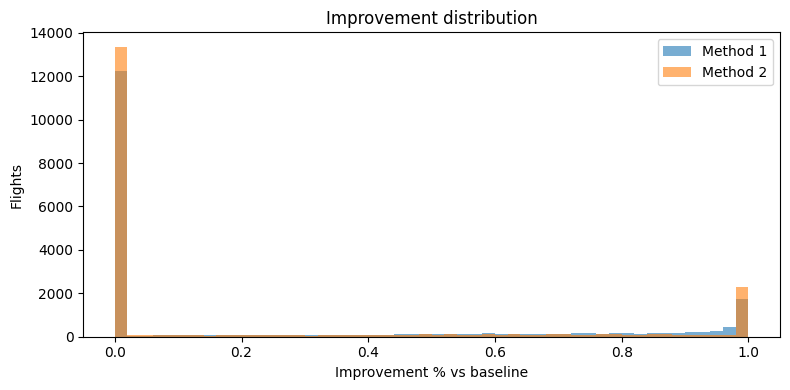

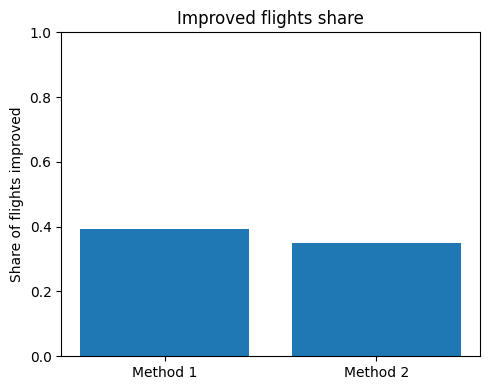

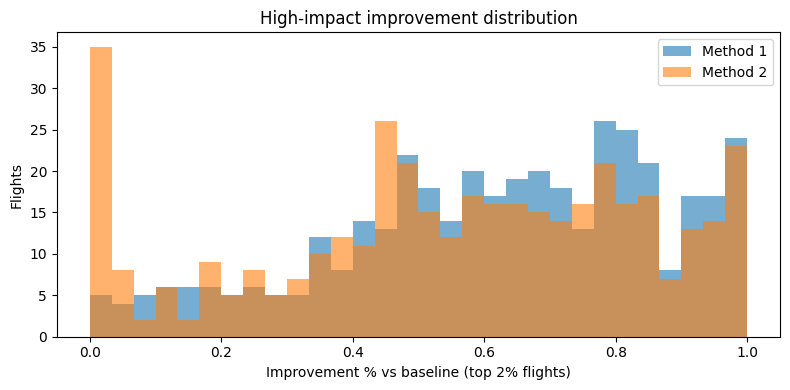

In [80]:
import matplotlib.pyplot as plt

# Distribution of improvement %
plt.figure(figsize=(8,4))
plt.hist(summary["method1_impr_pct"], bins=50, alpha=0.6, label="Method 1")
plt.hist(summary["method2_impr_pct"], bins=50, alpha=0.6, label="Method 2")
plt.xlabel("Improvement % vs baseline")
plt.ylabel("Flights")
plt.title("Improvement distribution")
plt.legend()
plt.tight_layout()
plt.show()

# Share improved bar
plt.figure(figsize=(5,4))
shares = [ (summary["method1_impr_abs"]>0).mean(), (summary["method2_impr_abs"]>0).mean() ]
plt.bar(["Method 1","Method 2"], shares)
plt.ylabel("Share of flights improved")
plt.title("Improved flights share")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# High-impact flights (top 2% baseline cost)
cut = summary["baseline_cost"].quantile(0.98)
hi = summary[summary["baseline_cost"] >= cut]
plt.figure(figsize=(8,4))
plt.hist(hi["method1_impr_pct"], bins=30, alpha=0.6, label="Method 1")
plt.hist(hi["method2_impr_pct"], bins=30, alpha=0.6, label="Method 2")
plt.xlabel("Improvement % vs baseline (top 2% flights)")
plt.ylabel("Flights")
plt.title("High-impact improvement distribution")
plt.legend()
plt.tight_layout()
plt.show()


## 13) Contrail impact comparison (total cost)

Lower is better. We compare total contrail cost across baseline, Method 1, and Method 2.


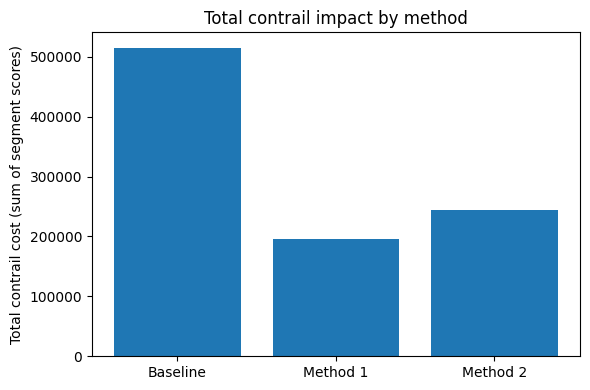

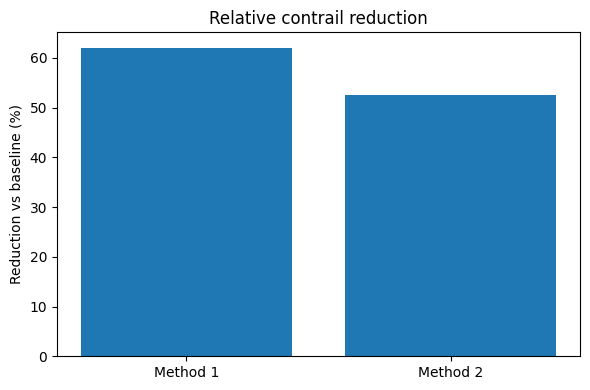

In [81]:
import matplotlib.pyplot as plt

# Total contrail impact (sum of costs)
base_total = summary["baseline_cost"].sum()
m1_total = summary["method1_cost"].sum()
m2_total = summary["method2_cost"].sum()

plt.figure(figsize=(6,4))
plt.bar(["Baseline", "Method 1", "Method 2"], [base_total, m1_total, m2_total])
plt.ylabel("Total contrail cost (sum of segment scores)")
plt.title("Total contrail impact by method")
plt.tight_layout()
plt.show()

# Relative reduction (%) vs baseline
red1 = 100 * (base_total - m1_total) / base_total if base_total > 0 else 0.0
red2 = 100 * (base_total - m2_total) / base_total if base_total > 0 else 0.0

plt.figure(figsize=(6,4))
plt.bar(["Method 1", "Method 2"], [red1, red2])
plt.ylabel("Reduction vs baseline (%)")
plt.title("Relative contrail reduction")
plt.tight_layout()
plt.show()


## 14) Alternative visualizations (choose later)

These plots provide richer views than a single bar chart.


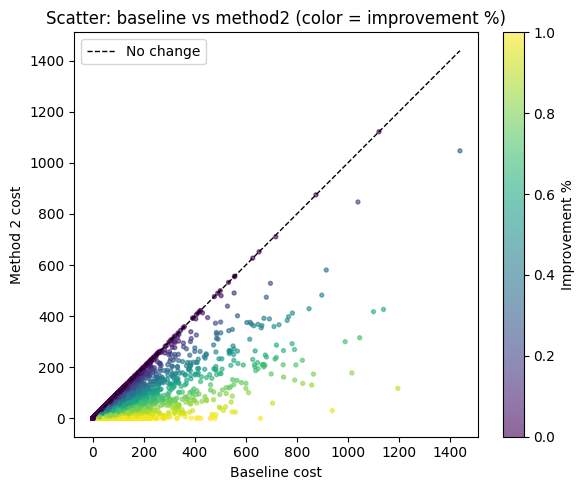

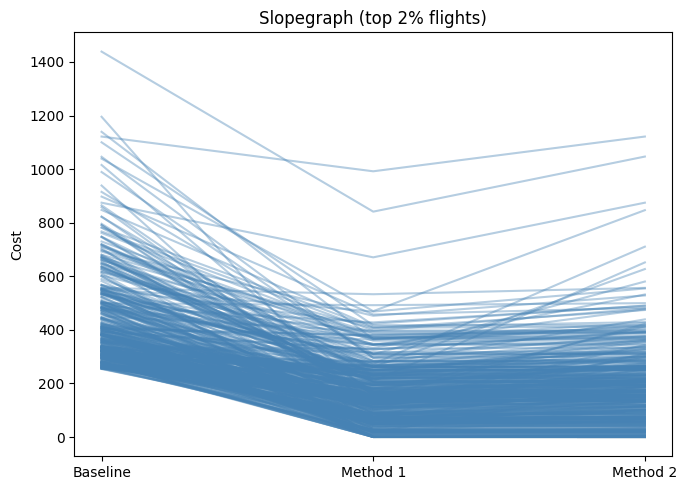

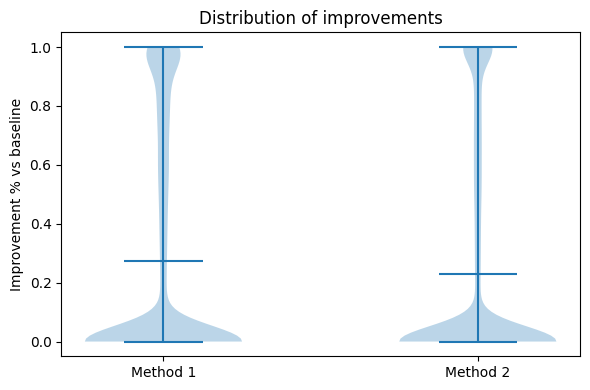

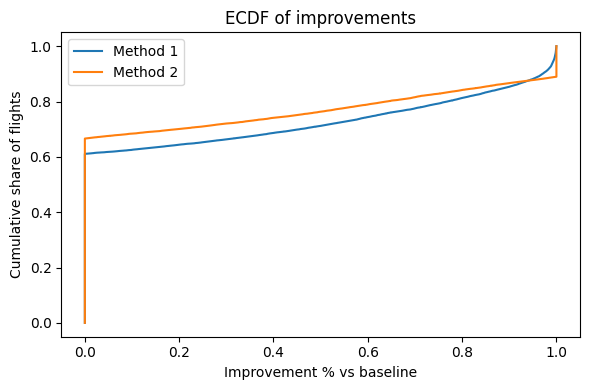

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# --- Option A: Scatter (baseline vs method) with color by improvement ---
plt.figure(figsize=(6,5))
imp = summary["method2_impr_pct"]
plt.scatter(summary["baseline_cost"], summary["method2_cost"], c=imp, cmap='viridis', s=8, alpha=0.6)
maxv = max(summary["baseline_cost"].max(), summary["method2_cost"].max())
plt.plot([0, maxv], [0, maxv], 'k--', lw=1, label='No change')
plt.xlabel('Baseline cost')
plt.ylabel('Method 2 cost')
plt.title('Scatter: baseline vs method2 (color = improvement %)')
plt.colorbar(label='Improvement %')
plt.legend()
plt.tight_layout()
plt.show()

# --- Option B: Slopegraph for top 2% flights ---
cut = summary["baseline_cost"].quantile(0.98)
hi = summary[summary["baseline_cost"] >= cut].copy()
plt.figure(figsize=(7,5))
for _, row in hi.iterrows():
    plt.plot([0,1,2], [row['baseline_cost'], row['method1_cost'], row['method2_cost']],
             color='steelblue', alpha=0.4)
plt.xticks([0,1,2], ['Baseline','Method 1','Method 2'])
plt.ylabel('Cost')
plt.title('Slopegraph (top 2% flights)')
plt.tight_layout()
plt.show()

# --- Option C: Violin plots of improvement % ---
plt.figure(figsize=(6,4))
plt.violinplot([summary["method1_impr_pct"], summary["method2_impr_pct"]], showmeans=True)
plt.xticks([1,2], ['Method 1','Method 2'])
plt.ylabel('Improvement % vs baseline')
plt.title('Distribution of improvements')
plt.tight_layout()
plt.show()

# --- Option D: ECDF of improvement % ---
plt.figure(figsize=(6,4))
for label, vals, col in [('Method 1', summary["method1_impr_pct"], 'tab:blue'),
                         ('Method 2', summary["method2_impr_pct"], 'tab:orange')]:
    x = np.sort(vals)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, label=label, color=col)
plt.xlabel('Improvement % vs baseline')
plt.ylabel('Cumulative share of flights')
plt.title('ECDF of improvements')
plt.legend()
plt.tight_layout()
plt.show()


## 13) Save interim outputs

Save action-ready segments, summary tables, and the cost table for future RL work.


In [83]:
from pathlib import Path

INTERIM = ROOT / "data" / "interim"
DATE = "2025-01-13_2025-01-14"

seg_out = INTERIM / "segments_with_era5_all_levels" / DATE
summary_out = INTERIM / "summaries" / DATE
rl_out = INTERIM / "cost_tables" / DATE

seg_out.mkdir(parents=True, exist_ok=True)
summary_out.mkdir(parents=True, exist_ok=True)
rl_out.mkdir(parents=True, exist_ok=True)

# 1) Action-ready segments (wide format)
segments_out = seg_out / "segments_rhi_hold_up_down.parquet"
segments.to_parquet(segments_out, index=False)

# 2) Summary tables
# baseline summary
baseline = cost_table.groupby("flight_id")["cost_hold"].sum().rename("baseline_cost").reset_index()

# method 1 summary (one change + fuel)
method1 = best_fuel[["flight_id","best_cost"]].rename(columns={"best_cost":"method1_cost"})

# method 2 summary (hourly grid + fuel + max changes)
method2 = res_hourly[["flight_id","best_cost"]].rename(columns={"best_cost":"method2_cost"})

summary = baseline.merge(method1, on="flight_id", how="left").merge(method2, on="flight_id", how="left")
summary["method1_impr_abs"] = summary["baseline_cost"] - summary["method1_cost"]
summary["method1_impr_pct"] = np.where(summary["baseline_cost"]>0, summary["method1_impr_abs"]/summary["baseline_cost"], 0.0)
summary["method2_impr_abs"] = summary["baseline_cost"] - summary["method2_cost"]
summary["method2_impr_pct"] = np.where(summary["baseline_cost"]>0, summary["method2_impr_abs"]/summary["baseline_cost"], 0.0)

summary_path = summary_out / "baseline_method1_method2_summary.parquet"
summary.to_parquet(summary_path, index=False)

# 3) Cost table for future RL
cost_table_path = rl_out / "rl_episode_table.parquet"
cost_table.to_parquet(cost_table_path, index=False)

print("Saved segments to:", segments_out)
print("Saved summary to:", summary_path)
print("Saved RL table to:", cost_table_path)


Saved segments to: c:\Users\HiWi\Desktop\Terril\01_nextcloud\Germany\DATA SCIENCE\Semesters\05\02 Sustainability in aviation\03 contrail-mvp\data\interim\segments_with_era5_all_levels\2025-01-13_2025-01-14\segments_rhi_hold_up_down.parquet
Saved summary to: c:\Users\HiWi\Desktop\Terril\01_nextcloud\Germany\DATA SCIENCE\Semesters\05\02 Sustainability in aviation\03 contrail-mvp\data\interim\summaries\2025-01-13_2025-01-14\baseline_method1_method2_summary.parquet
Saved RL table to: c:\Users\HiWi\Desktop\Terril\01_nextcloud\Germany\DATA SCIENCE\Semesters\05\02 Sustainability in aviation\03 contrail-mvp\data\interim\rl_inputs\2025-01-13_2025-01-14\rl_episode_table.parquet


## 11) RL (future extension)

For multi-step decisions under uncertainty or additional constraints, RL can learn a policy that adapts to state. This notebook keeps exact optimization for Methods 1 and 2; RL can be added later for stochastic or richer constraints.


## 9) Evaluation summary (baseline)

Compare no-change vs best one-change and summarize gains, with a focus on high-impact flights.


In [84]:
import numpy as np

# overall improvement summary
print("Improvement % summary:")
print(best["improvement_pct"].describe())

# share of flights with any benefit
print("Share with improvement > 0:", (best["improvement_abs"] > 0).mean())

# focus on high-impact flights (top 2% by no-change cost)
cut = best["no_change_cost"].quantile(0.98)
hi = best[best["no_change_cost"] >= cut].copy()
print("High-impact flights (top 2%) count:", len(hi))
print("High-impact improvement % summary:")
print(hi["improvement_pct"].describe())

print("Chosen action counts (all):")
print(best["best_action"].value_counts())
print("Chosen action counts (high-impact):")
print(hi["best_action"].value_counts())


Improvement % summary:
count    1.991600e+04
mean     2.823101e-01
std      3.979918e-01
min     -3.621486e-16
25%      0.000000e+00
50%      0.000000e+00
75%      6.421258e-01
max      1.000000e+00
Name: improvement_pct, dtype: float64
Share with improvement > 0: 0.3985237999598313
High-impact flights (top 2%) count: 399
High-impact improvement % summary:
count    3.990000e+02
mean     6.204777e-01
std      2.483833e-01
min      2.168241e-16
25%      4.661899e-01
50%      6.500810e-01
75%      8.147805e-01
max      1.000000e+00
Name: improvement_pct, dtype: float64
Chosen action counts (all):
best_action
HOLD    12030
UP       3985
DOWN     3901
Name: count, dtype: int64
Chosen action counts (high-impact):
best_action
DOWN    327
UP       72
Name: count, dtype: int64
